In [2]:
#xmlファイルを読んでピクセル座標に変換
#fitsからaperture photometryやっちゃう
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import astropy.wcs
from astropy.io import fits
import astropy.io
from astropy.stats import sigma_clipped_stats
from photutils import datasets
from photutils import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from photutils import CircularAnnulus
from scipy.optimize import curve_fit
from photutils import aperture_photometry
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import clear_output

df = pd.read_csv("simultaneous_event_candidates_table_MU+Tomo-e8.csv")
#df = pd.read_csv("test8.csv")
df["ID_fits"] = "d_fits/sub" + df["ID"] + ".fits"
ID_list_fits = df["ID_fits"].values
############################################ リチェックするフレーム #####
d_list = ["d_fits/sub627032_102.fits","d_fits/sub665114_014.fits"]
d_idx = np.arange(1).reshape(1) 
for i in d_list:
    for j in range(len(ID_list_fits)):
        if i == ID_list_fits[j]:
            d_idx = np.vstack((d_idx, j))
d_idx = np.delete(d_idx,0)
print ID_list_fits[d_idx]
df = df.drop(d_idx) #d_listの該当する行だけ消してる
###############################################################
df["ID_xml"] = "sub" + df["ID"] + ".xml"
df["ID_fits"] = "d_fits/sub" + df["ID"] + ".fits"
ID_list_xml = df["ID_xml"].values
ID_list_fits = df["ID_fits"].values
meteor_flux_list = df["flux_meteor"].values

def gauss(x, A, mu, sigma):
    return A / np.sqrt(2.0*np.pi) / sigma * np.exp(-((x-mu)/sigma)**2/2)

with open("d_xml/sub571226_095.xml") as f:
    a = f.readlines()
    b = a[50]#<TABLEDATA>
    c = a[77] #</TABLEDATA>

mag_vr = np.arange(1).reshape(1)#starと比較して最終的に流星のmag_videorateが欲しい
star_num = np.arange(1).reshape(1)
dispersion = np.arange(1).reshape(1)
for (filename_fits, filename_xml,idx) in zip(ID_list_fits, ID_list_xml,range(len(ID_list_fits))):
    filename_xml = "d_xml/" + filename_xml
    meteor_flux = meteor_flux_list[idx]
    print filename_fits,meteor_flux
###################################### xml ファイルの読み込み #######
#################################恒星の(ra, dec, Vmag)のリストにする###
    with open(filename_xml) as f:
        l = f.readlines()
        for i in range(len(l)):
            m = l[i]
            if m == b:
                del_start = i + 1
            elif m == c:
                del_end = i
    l = l[del_start:del_end]
    xml = l[0]
    xml = re.split('<TR><TD>|</TD><TD>|</TD></TR>', xml)
    del xml[0],xml[2:8],xml[3:]
    for i in l:
        s = re.split('<TR><TD>|</TD><TD>|</TD></TR>', i)
        del s[0],s[2:8],s[3:]
        xml = np.vstack((xml, s))
    xml = np.delete(xml,0, 0)
    xml = xml.astype(np.float64)
##############################################################
######################## World Coordinates System to Pixel Coordinates ###
    pixel_coordinates = np.arange(2).reshape(1,2)
    fits = astropy.io.fits.open(filename_fits)
    hdul = fits
    data = hdul[0].data
    data2 = data[1,:,:]#差分前のフレームだけにする
    data2 = np.reshape(data2, (282, 500))#2次元化
    wcs = astropy.wcs.WCS(fits[0].header, naxis = 2)
    for j in range(len(xml)):
            pixel_coord = wcs.all_world2pix(xml[j,0], xml[j,1], 1)
            pixel_coordinates = np.vstack((pixel_coordinates, pixel_coord))
    pixel_coordinates = np.delete(pixel_coordinates,0, 0)
###############################################################
################################# Remove the stars outside the frame ###
    index = np.arange(1).reshape(1)
    for i in range(len(pixel_coordinates)):
        x = pixel_coordinates[i,0]
        y = pixel_coordinates[i,1]
        if (x < 0) or (x > 490) or (y < 0) or (y > 282):
#x座標が490なのはガウスフィットするときに±10pix抜き出すからはみ出ないように490に設定
            index = np.vstack((index, i))
    index = np.delete(index,0, 0)
    pixel_coordinates = np.delete(pixel_coordinates,index, 0)
    xml = np.delete(xml,index, 0)
    vmag = xml[:,2]
###############################################################
############ Gaussian profile of catalog stars to estimate aperture's parameters ###
    star_flux = np.arange(1).reshape(1)
    for i in range(len(pixel_coordinates)):
        xr1 = pixel_coordinates[i,0] - 10
        xr2 = pixel_coordinates[i,0] + 10
        xr1 = xr1.astype(int)
        xr2 = xr2.astype(int)
        xr = range(xr1, xr2, 1)
        yr = pixel_coordinates[i,1]
        yr = yr.astype(int)
        y =  data2[yr,xr]
        A_para = y.max()
        mu_para = pixel_coordinates[i,0]
        p0 = [A_para, mu_para, 1.] # パラメータの初期値(A, mu, sigma)
        parameter,_ = curve_fit(gauss, xr, y, p0=p0)
        sigma = parameter[2]
        fwhm = 2*parameter[2]*(np.sqrt(2*np.log(2)))
        xx = np.linspace(xr1, xr2, 100)
        yy = gauss(xx, *parameter)
        #ax = plt.subplot()
        #plt.plot(xr, y, 'c.')
        #plt.plot(xx, yy, 'r-')
        #plt.show()
        #file_name = star_photometry_filename[i]
        #plt.savefig(file_name)
        
##################################################################
####################################### Conducting aperture photometry ###
        positions = pixel_coordinates[i,:]
        aperture_radius = 1.5*fwhm
        inner_radius = aperture_radius + fwhm
        outer_radius = 5*fwhm
        apertures = CircularAperture(positions, r=aperture_radius)
        annulus_apertures = CircularAnnulus(positions, r_in=inner_radius, r_out=outer_radius)
        apers = [apertures, annulus_apertures]
        phot_table = aperture_photometry(data2, apers)
        for col in phot_table.colnames:
            phot_table[col].info.format = '%.8g'
        bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
        bkg_sum = bkg_mean * apertures.area()
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
        phot_table['residual_aperture_sum'] = final_sum
        phot_table['residual_aperture_sum'].info.format = '%.8g'
        aperture_sum = np.array(phot_table["residual_aperture_sum"][:])
        star_flux = np.vstack((star_flux, aperture_sum))
        #print (phot_table)
        #print aperture_sum
    star_flux = np.delete(star_flux,0, 0)
    if len(xml)==0: #カタログ恒星がすべてフレーム外だった場合
            xml = np.zeros((1,3))
            star_flux = np.zeros((1,1))
    xml = np.hstack((xml,star_flux))
###################################################################
####################################  Comparison star flux and meteor flux ###
    m_vr = np.arange(1).reshape(1)
    for i in range(len(xml)):
        video_rate_magnitude = xml[i,2] - 2.5*np.log10(meteor_flux/xml[i,3]) 
        m_vr = np.vstack((m_vr, video_rate_magnitude))
    m_vr = np.delete(m_vr,0, 0)
    star_number = len(m_vr)
    m_average = np.average(m_vr)
    deviation = m_vr - m_average
    deviation = np.power(deviation,2)
    disp = np.sqrt(np.sum(deviation)/len(m_vr))
    #xml = np.hstack((xml,m_vr))
    m_vr = np.average(m_vr)
    mag_vr = np.hstack((mag_vr,m_vr))
    star_num = np.hstack((star_num,star_number))
    dispersion = np.hstack((dispersion,disp))

mag_vr = np.delete(mag_vr,0, 0)
star_num = np.delete(star_num,0, 0)
dispersion = np.delete(dispersion,0, 0)
###############################################################絶対等級
alt = df["Beginning_height_km_"].values #[km]
distance = 170 #[km]
alt = np.power(alt, 2)
distance = np.power(distance, 2)
l = alt + distance
l = l.astype(np.float64)
l = np.sqrt(l)
abs_mag = mag_vr + 10 - 5*np.log10(l) #100km換算の絶対等級
abs_mag_error = dispersion + 10 - 5*np.log10(l)
###################################################################
for i in range(len(meteor_flux_list)): ## 流星のフラックスが測れてない場合等級もゼロにする
    if meteor_flux_list[i] == 0:
        mag_vr[i] = 0
        abs_mag[i] = 0
df["mag_vr"] = mag_vr
df["mag_err"] = dispersion
df["star_num"] = star_num
df["abs_mag"] = abs_mag
df["abs_mag_err"] = abs_mag_error
###################################################################
####################################  Create new .csv file ###
#df = pd.concat([df, df_mag_vr], axis=1)
Columns = df.columns
for i in range(len(Columns)):
    if Columns[i] == "ID":
        index = i
Columns = Columns[0:index]
df = df.drop(columns=Columns)
df = df.drop(columns="ID_xml")
df = df.drop(columns="ID_fits")
#df.to_csv("test9.csv")
df.to_csv("simultaneous_event_candidates_table_MU+Tomo-e9.csv")
clear_output()
print "Complete!"
####################################################################


### aperture内に他のsourceがある場合、除く
### 流星の飛跡付近のマスキング
### 

Complete!


Complete!


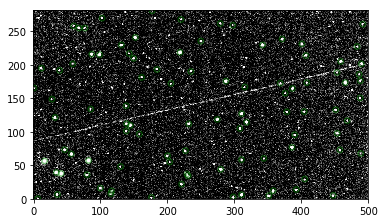

In [2]:
from astropy.stats import sigma_clipped_stats
from photutils import datasets
import pandas as pd
import numpy as np
import astropy.io
import matplotlib.pyplot as plt
from photutils import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

hdul = astropy.io.fits.open("d_fits/sub571226_095.fits")
data = hdul[0].data
data2 = data[1,:,:]#差分前のフレームだけにする
data2 = np.reshape(data2, (282, 500))#2次元化
mean, median, std = sigma_clipped_stats(data2, sigma=3.0)    
#print((mean, median, std))  
daofind = DAOStarFinder(fwhm=3.0, threshold=20.*std)    
sources = daofind(data2 - median)    
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output
#print sources
#print sources["xcentroid"][:]
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)
plt.imshow(data2, cmap = 'gray', vmin = 0, vmax = 400, interpolation = 'none')
apertures.plot(color='green', lw=1.5, alpha=0.5)
plt.ylim(0, 282)
print "Complete!"